In [1]:
import warnings
warnings.filterwarnings("ignore")

# basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# for graphs
%config InlineBackend.figure_format = 'retina'  
plt.rcParams['figure.figsize'] = 8, 5          
plt.rcParams['font.size'] = 12                  
#mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')


### Data downloading

In [2]:
data = pd.read_excel('Data.xlsx')
data = data.rename(columns={'Value': 'UnEmp'})
data['Date'] = pd.to_datetime(data['Date'])
data['UnEmp_d'] = data['UnEmp'].diff(1).shift(1)
data = data.set_index('Date')

In [3]:
data.head(4)

,UnEmp,UnEmp_d
Date,,
1948-01-01,3.4,NaN
1948-02-01,3.8,NaN
1948-03-01,4.0,0.4
1948-04-01,3.9,0.2


Usual ML splitting: 70-30

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, shuffle=False)

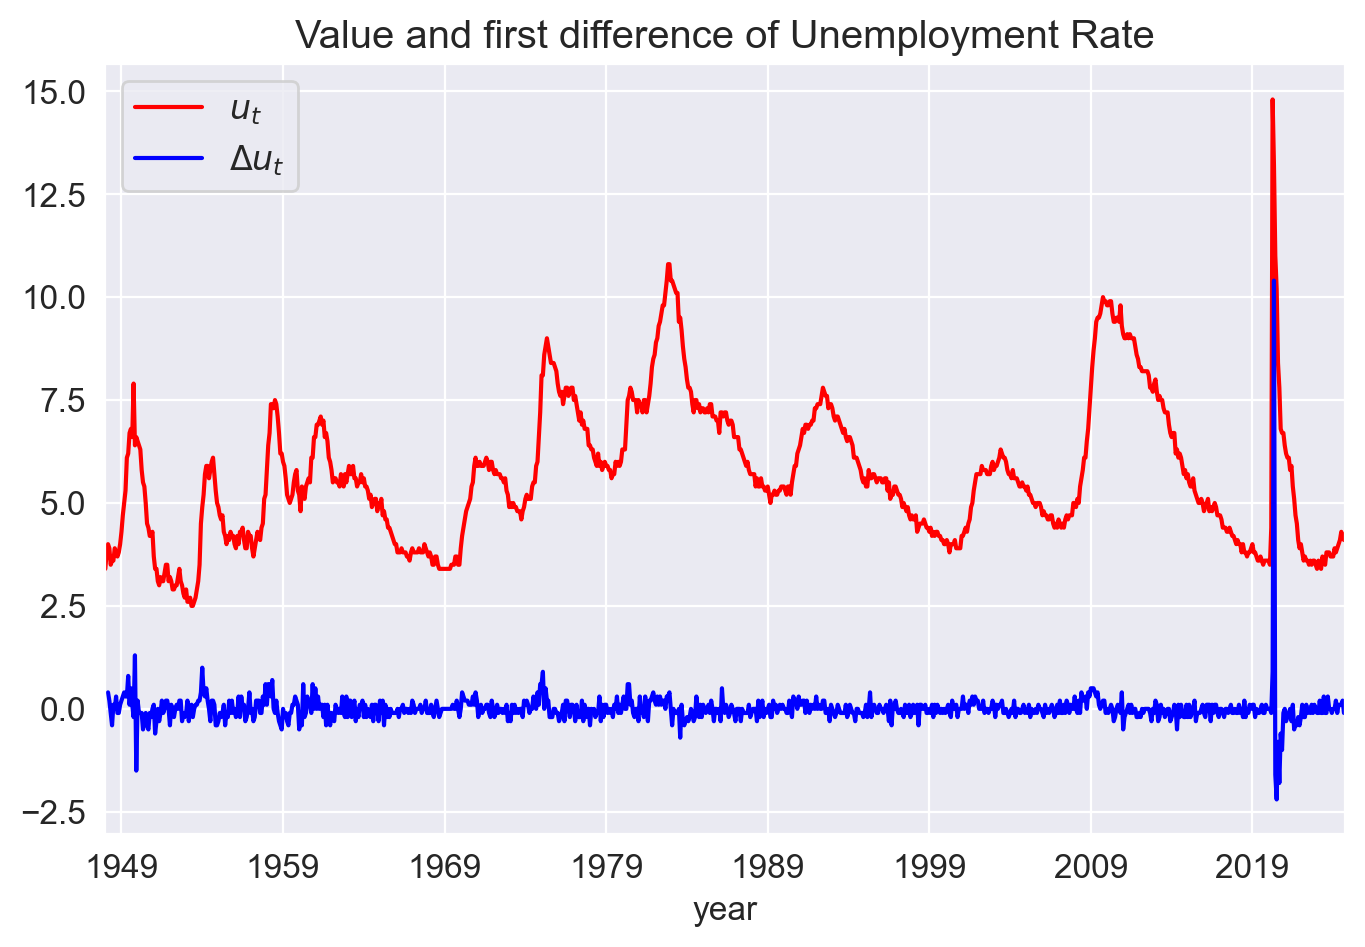

In [5]:
ax = data.plot(y='UnEmp', label='$u_t$', color='red') 
data.plot(ax=ax,y='UnEmp_d', label='$\Delta u_t$', color='blue') 
plt.title('Value and first difference of Unemployment Rate') 
plt.xlabel('year') 
plt.legend()

plt.show()

## 1) AR models selection

In [6]:
# Suppress warnings
from statsmodels.tsa.ar_model import AutoReg, AutoRegResults
warnings.filterwarnings("ignore")

def find_optimal_lag(max_lag, time_series):
    lag_orders = range(1, max_lag + 1)
    bic_values = [0] * max_lag
    
    for lag in lag_orders:
        model = AutoReg(time_series, lags=lag, trend='n').fit()
        bic_values[lag - 1] = round(model.bic, 3)
    
    optimal_lag = lag_orders[bic_values.index(min(bic_values))]
    
    print(f"Optimal lag order based on BIC: {optimal_lag}")

In [7]:
unemployment_diff = train['UnEmp_d'].dropna()
maximum_lag = 10
find_optimal_lag(maximum_lag, unemployment_diff)

Optimal lag order based on BIC: 4


In [8]:
from statsmodels.iolib.summary2 import summary_col
res = AutoReg(train['UnEmp_d'].dropna(), lags = [1,2,3,4]).fit()
output = summary_col(res,stars=True, float_format='%4.3f')
output

,UnEmp_d
const,0.002
,(0.008)
UnEmp_d.L1,0.005
,(0.039)
UnEmp_d.L2,0.246***
,(0.039)
UnEmp_d.L3,0.179***
,(0.039)
UnEmp_d.L4,0.076*
,(0.039)


In [9]:
with open('model_1.tex', 'w') as f:
    f.write(output.as_latex())

## 2) Ljung-Box and ACF

Ljung-Box Test:
      lb_stat  lb_pvalue
1    0.017666   0.894262
2    0.089773   0.956106
3    0.098665   0.991997
4    0.337172   0.987290
5    6.579002   0.253879
6    6.657495   0.353686
7    6.975831   0.431401
8    7.796504   0.453597
9    7.888613   0.545409
10  13.383918   0.202991


<Figure size 800x500 with 0 Axes>

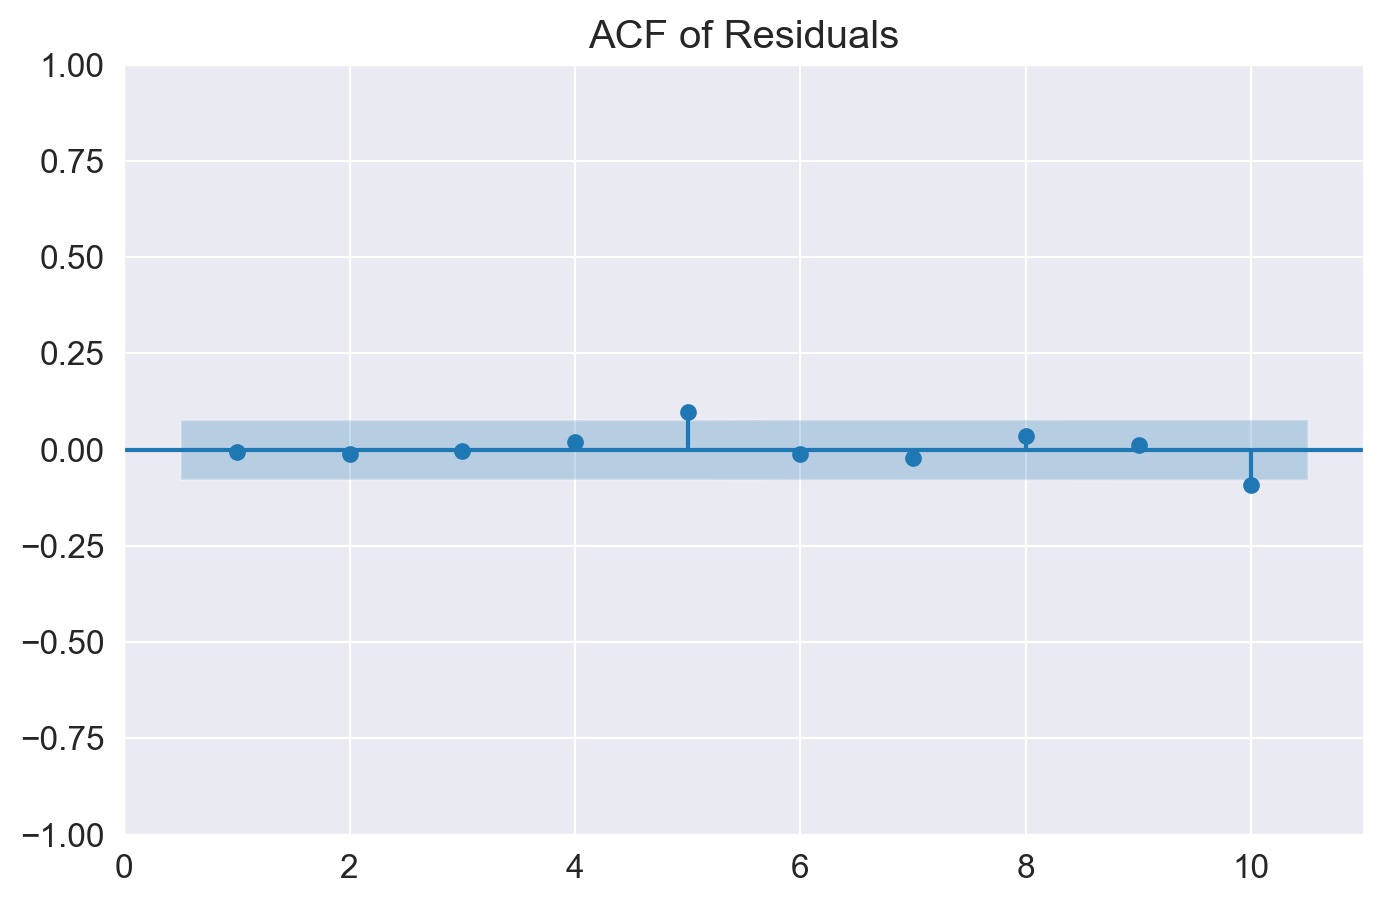

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
jung_box= acorr_ljungbox(res.resid, lags=range(1,11), return_df=True)

print("Ljung-Box Test:")
print(jung_box)

plt.figure()
plot_acf(res.resid, lags=range(1,11), title='ACF of Residuals')
plt.show()

## 3) IRF

In [11]:
model = sm.tsa.arima.ARIMA(train['UnEmp'].dropna(), order=(4, 1, 0))
res = model.fit()

model_L1 = sm.tsa.arima.ARIMA(train['UnEmp_d'].dropna(), order=(4, 0, 0))
res_L1 = model_L1.fit()

IRF_level = res.impulse_responses(steps=10, impulse=0)
IRF_diff = res_L1.impulse_responses(steps=10, impulse=0)
# steps=10 specifies the impulse response for the next 10 periods.
# impulse=0 shock to the first variable

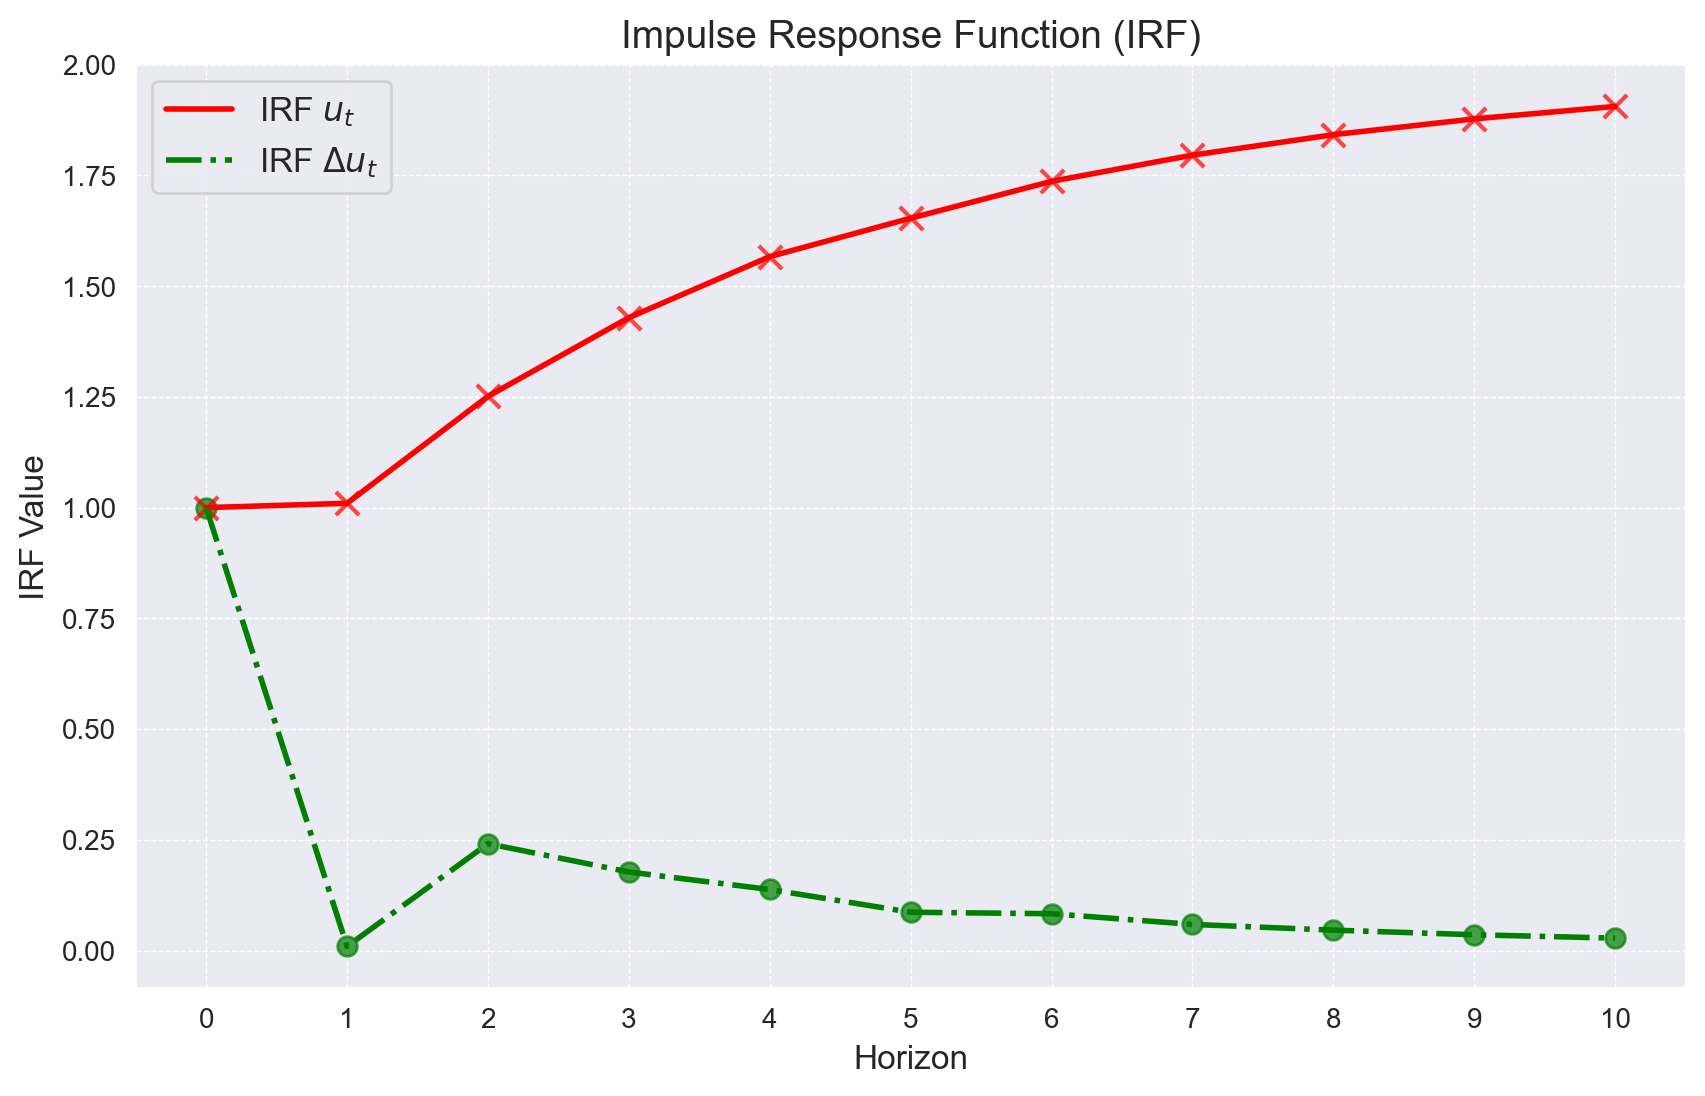

In [12]:
# Plotting alternative style for IRF
plt.figure(figsize=(10, 6))
plt.plot(IRF_level, color="red", linewidth=2, label='IRF $u_t$')
plt.plot(IRF_diff, linestyle='-.', color="green", linewidth=2, label='IRF $\Delta u_t$')
plt.scatter(range(11), IRF_diff, color="green", marker='o', s=50, alpha=0.7)
plt.scatter(range(11), IRF_level, color="red", marker='x', s=70, alpha=0.7)
plt.xlabel('Horizon', fontsize=12)
plt.ylabel('IRF Value', fontsize=12)
plt.xticks(range(11), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.title('Impulse Response Function (IRF)', fontsize=14)

plt.show()

## 4) Multiperiod forecasts

<Figure size 1200x700 with 0 Axes>

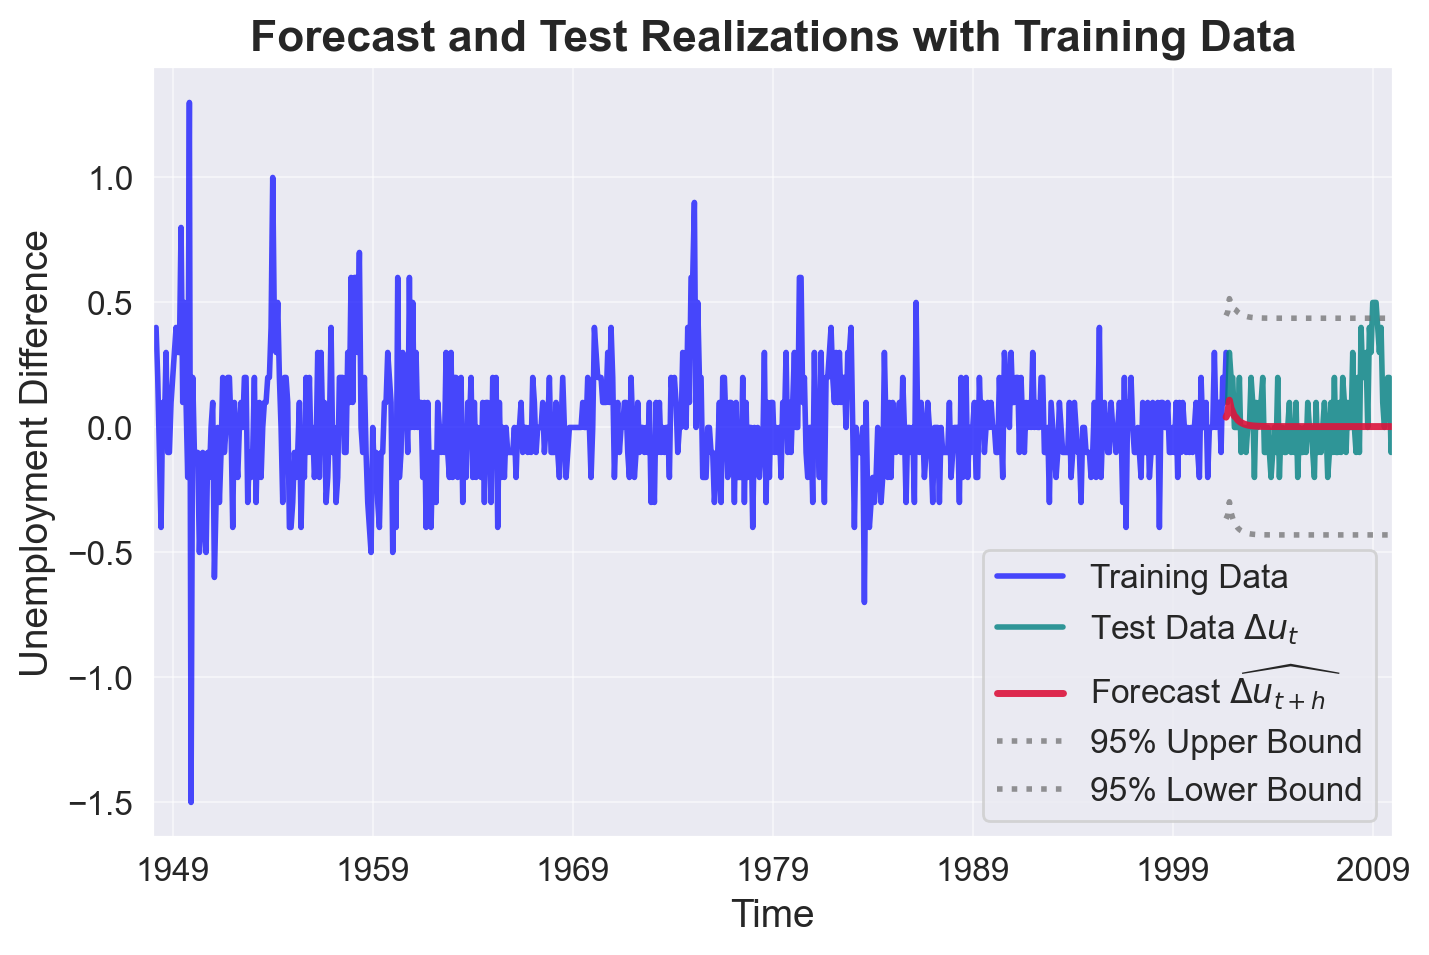

In [13]:
res = AutoReg(train['UnEmp_d'].dropna(), lags = [1,2,3,4]).fit()
pred = res.get_prediction(start=train.index[-1], end=test.index[-1])


forecast = pred.summary_frame()
forecast = forecast[['mean', 'mean_se']]

forecast['upper'] = forecast['mean'] + 1.96*forecast['mean_se']
forecast['lower'] = forecast['mean'] - 1.96*forecast['mean_se']

horizon = 100

test_for_plot = test.iloc[0:horizon, :]
forecast_plot = forecast.iloc[0:horizon, :]

plt.figure(figsize=(12, 7))
ax = train.plot(y='UnEmp_d', label='Training Data', color='blue', linewidth=2, linestyle='-', alpha=0.7)
test_for_plot.plot(ax=ax, y='UnEmp_d', label='Test Data $\Delta u_t$', color='teal', linewidth=2, linestyle='-', alpha=0.8)

forecast_plot.plot(ax=ax, y='mean', label='Forecast $\widehat{\Delta u_{t+h}}$', color='crimson', linewidth=2.5, linestyle='-', alpha=0.9)

forecast_plot.plot(ax=ax, y='upper', linestyle=':', label='95% Upper Bound', color='dimgray', linewidth=2, alpha=0.7)
forecast_plot.plot(ax=ax, y='lower', linestyle=':', label='95% Lower Bound', color='dimgray', linewidth=2, alpha=0.7)

# Add title and labels
plt.title('Forecast and Test Realizations with Training Data', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Unemployment Difference', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='-', linewidth=0.7, alpha=0.5)
plt.legend(fontsize=12, loc='lower right')

plt.show()

## 5) ADF

In [14]:
from statsmodels.tsa.stattools import adfuller
ADF = adfuller(train['UnEmp'], maxlag=4, regression = 'c')

In [15]:
print(f'critical values: {ADF[4]}')
print(f'ADF statistic: {ADF[0]}')

critical values: {'1%': -3.4406089407081604, '5%': -2.866066583404541, '10%': -2.5691806079101562}
ADF statistic: -3.6471270353211245
